In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

C:\Users\Jaesung\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#uav_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/RW_AUDIO_DATA_2018_Update/RW_AUDIO_DATA_2018_Update/JUNE_01_PHANTOMS/P1_stationary.wav'
#none_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/RW_AUDIO_DATA_2018_Update/RW_AUDIO_DATA_2018_Update/JUNE_02_BACKGROUND/background_06_02_01.wav'
#C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/Sounddata_new/Sound
#uav_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/Sounddata_new/Sound/Drone52.wav'
#uav_path = 'C:/Users/Jaesung/Desktop/Drone52.wav'
#none_path = '../../../RW_AUDIO_DATA_2018_Update/Background*.wav
 
uav_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/Sounddata_new/audio/test/unloaded/*.wav'
loaded_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/Sounddata_new/audio/test/loaded/*.wav'
none_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/Sounddata_new/audio/test/background/*.wav'

#none_path = 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/RW_AUDIO_DATA_2018_Update/RW_AUDIO_DATA_2018_Update/JUNE_02_BACKGROUND/background_0*.wav'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw= load(loaded_files)
none_raw = load(none_files)

(3968512,)
(3080192,)
(442368,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_loaded, y_loaded = mfcc4(loaded_raw, 2)
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
mfcc_none, y_none = mfcc4(none_raw, 0)

print(mfcc_uav.shape, y_uav.shape)
print(mfcc_loaded.shape, y_loaded.shape)
print(mfcc_none.shape, y_none.shape)

(3080192,)
small end: (16, 9)
(3968512,)
small end: (16, 16)
small end: (16, 8)
(442368,)
small end: (16, 9)
(967, 16, 16) (967,)
(751, 16, 16) (751,)
(107, 16, 16) (107,)


In [8]:
X = np.concatenate((mfcc_loaded, mfcc_uav, mfcc_none), axis=0)
y = np.hstack((y_loaded, y_uav, y_none))
print(X.shape, y.shape)

(1825, 16, 16) (1825,)


In [9]:
#X_test = np.reshape(X,(X.shape[0],-1)) 
X_test = X.reshape(X.shape[0],-1)

In [10]:
n_labels = y.shape[0]
n_unique_labels = 3
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(1825, 3)


# test init

In [11]:
tf.reset_default_graph()

In [12]:
n_mfcc = 16
n_frame = 16
n_classes = 3
n_channels = 1

learning_rate = 0.0002  # 0.005

In [13]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
#X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels]) #fully connected에는 리셰입 안해도 된다 
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

#dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
#dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=True)

dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)


dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)

dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)

#이거 지워보고 돌려보고 
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)


dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)


logits= tf.layers.dense(inputs=dropout5, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [14]:
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 'C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/GIt/uav-audio-detection/models/CNN/my_test_model_cnn')
#saver.restore(sess, '../models/CNN/my_test_model_cnn')

y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test,keep_prob:1 })
y_true = sess.run(tf.argmax(y_encoded,1))

INFO:tensorflow:Restoring parameters from C:/Users/Jaesung/Desktop/코딩/Python실습/K-SW-PJT/GIt/uav-audio-detection/models/CNN/my_test_model_cnn


F-Score: 0.958
Accuracy:  0.9578082191780822
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       107
          1       0.93      1.00      0.96       967
          2       0.99      0.90      0.95       751

avg / total       0.96      0.96      0.96      1825

[[107   0   0]
 [  0 963   4]
 [  0  73 678]]


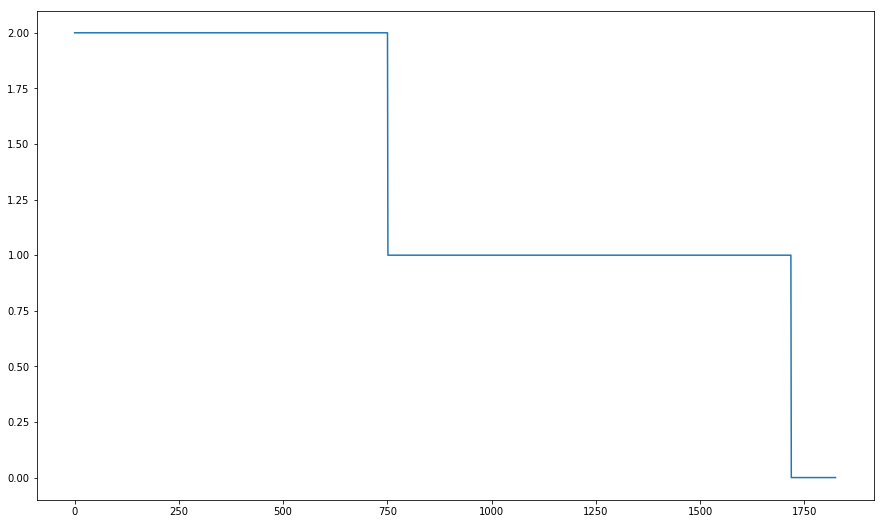

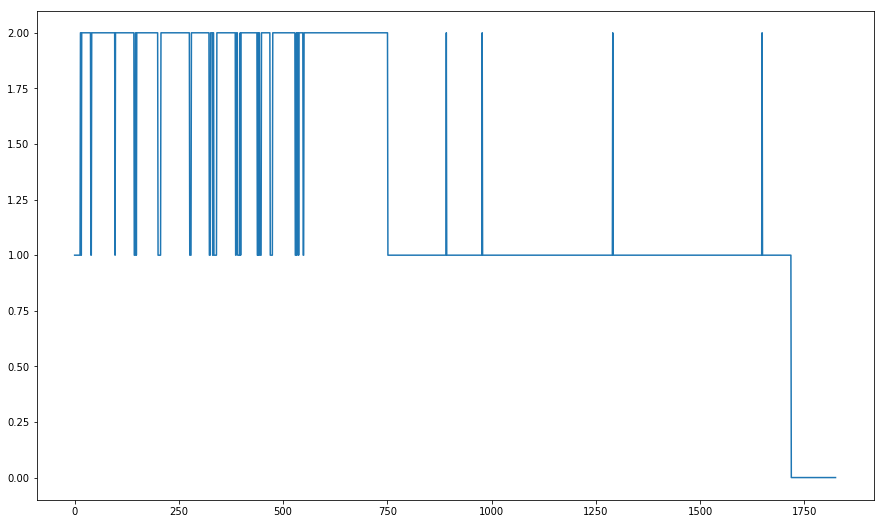

In [15]:
from sklearn.metrics import precision_recall_fscore_support
y_true = y_true
y_pred = y_pred

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))


fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)


from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))